In [1]:
print('Hello world')

Hello world


# Spacecraft and ISO Trajectory

In [2]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
from astropy import constants as c
from astropy.coordinates import SkyCoord, solar_system_ephemeris, get_body_barycentric_posvel, CartesianRepresentation, CartesianDifferential
from astropy.time import Time

import scipy.integrate as integrate

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['figure.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['mathtext.fontset'] = 'cm'

# plt.style.use('dark_background')

In [3]:
def hyperbolic_mean_to_eccentric_anomaly(M, e, tol=1e-10, max_iter=100):
    '''
    Convert hyperbolic mean anomaly to hyperbolic eccentric anomaly using Newton-Raphson method.

    Parameters
    ----------
    M : float
        Hyperbolic mean anomaly in radians
    e : float
        Eccentricity (e > 1 for hyperbolic orbits)
    tol : float
        Tolerance for convergence
    max_iter : int
        Maximum number of iterations

    Returns
    -------
    F : float
        Hyperbolic eccentric anomaly in radians
    k : int
        Number of iterations taken to converge
    '''
    if e <= 1:
        raise ValueError("Eccentricity must be greater than 1 for hyperbolic orbits.")

    # Initial guess for F
    F = M

    # Newton-Raphson iterations
    for k in range(max_iter):
        # Calculating next correction
        delta_F = (M - (e * np.sinh(F) - F)) / (e * np.cosh(F) - 1)
        
        # Calculating next approximation
        F += delta_F

        # Check for convergence
        if abs(delta_F) < tol:
            break

    return F, k+1  # Return the number of iterations as well

def OEtoRV(orbital_elements: dict) -> dict:
    '''
    Convert orbital elements to state vectors.

    Parameters
    ----------
    orbital_elements : dict
        Dictionary containing heliocentric orbital elements:
        - a: Semi-major axis (astropy Quantity with length unit)
        - e: Eccentricity (float)
        - i: Inclination (astropy Quantity with angle unit)
        - Omega: Longitude of ascending node (astropy Quantity with angle unit)
        - omega: Argument of perihelion (astropy Quantity with angle unit)
        - M: Mean anomaly (astropy Quantity with angle unit)
        - epoch: Epoch of the elements (astropy Time object)

    Returns
    -------
    (r, v) : tuple of np.ndarray
        Position (r) and velocity (v) vectors in heliocentric frame [km] and [km/s]
    '''
    # Unpacking orbital elements and converting to appropriate units
    a = orbital_elements['a'].to(u.km).value
    e = orbital_elements['e']
    i = orbital_elements['i'].to(u.rad).value
    Omega = orbital_elements['Omega'].to(u.rad).value
    omega = orbital_elements['omega'].to(u.rad).value

    # Checking if mean anomaly or true anomaly is given:
    if 'M' in orbital_elements:
        M = orbital_elements['M'].to(u.rad).value
    elif 'nu' in orbital_elements:
        nu = orbital_elements['nu'].to(u.rad).value
    else:
        raise ValueError("Either mean anomaly (M) or true anomaly (nu) must be provided.")

    # Defining constants
    mu_sun = (c.G * c.M_sun).to(u.km**3 / u.s**2).value # Gravitational parameter of the Sun [km^3/s^2]
    h = np.sqrt(abs(mu_sun * a * (e**2 - 1)))  # Specific angular momentum [km^2/s]

    # Defining rotational matrices
    Rz_Omega = np.array([
        [ np.cos(Omega), np.sin(Omega), 0.0],
        [-np.sin(Omega), np.cos(Omega), 0.0],
        [0.0,         0.0,        1.0]
    ])

    Rx_i = np.array([
        [1.0,  0.0,       0.0],
        [0.0,  np.cos(i), np.sin(i)],
        [0.0, -np.sin(i), np.cos(i)]
    ])

    Rz_omega = np.array([
        [ np.cos(omega), np.sin(omega), 0.0],
        [-np.sin(omega), np.cos(omega), 0.0],
        [0.0,         0.0,        1.0]
    ])

    # DCM to go from inertial (heliocentric) frame to orbital frame
    R_OI = Rz_omega @ Rx_i @ Rz_Omega

    # Calculating position of object in the orbital frame
    # Solving Kepler's equation for Eccentric Anomaly (E) using Newton-Raphson method
    if 'M' in orbital_elements:
        if e < 1:
            # Elliptical orbit case (not used here, but for completeness)
            raise NotImplementedError("Elliptical orbits not implemented in this function.")

        else:
            # Hyperbolic orbit case
            F, k = hyperbolic_mean_to_eccentric_anomaly(M, e)

            # Calculating true anomaly (nu) from hyperbolic eccentric anomaly (F)
            nu = 2 * np.arctan2( np.sqrt((e + 1) / (e - 1)) * np.tan(F / 2), 1 )

            # Calculating distance (r) from the focus (Sun) to the object
            # r_mag = a * (1 - e*np.cosh(F))
            r_mag = (a * (1 - e**2)) / (1 + e * np.cos(nu))
    
    else:
        # If true anomaly is given directly
        r_mag = (a * (1 - e**2)) / (1 + e * np.cos(nu))

    # Position in orbital frame [km]
    r_orbital = np.array([
        r_mag * np.cos(nu),
        r_mag * np.sin(nu),
        0.0
    ])

    # Velocity in orbital frame [km/s]
    v_orbital = np.array([
        (mu_sun / h) * (-np.sin(nu)),
        (mu_sun / h) * (e + np.cos(nu)),
        0.0
    ])

    # Rotating position and velocity to heliocentric frame
    r_heliocentric = (np.transpose(R_OI) @ r_orbital * u.km).to(u.au)
    v_heliocentric = np.transpose(R_OI) @ v_orbital * u.km / u.s

    return (r_heliocentric, v_heliocentric)

def helio_RV_to_bary_RV(r_heliocentric, v_heliocentric, M, a, perihelion_epoch):
    '''
    Convert heliocentric state vectors to barycentric state vectors.

    Parameters
    ----------
    r_heliocentric : np.ndarray
        Position vector in heliocentric frame [km]
    v_heliocentric : np.ndarray
        Velocity vector in heliocentric frame [km/s]
    a : astropy Quantity with length unit
        Heliocentric semi-major axis
    M : astropy Quantity with angle unit
        Mean anomaly
    perihelion_epoch : astropy Time object
        Epoch of the perihelion passage

    Returns
    -------
    (r, v) : tuple of np.ndarray
        Position (r) and velocity (v) vectors in barycentric frame [km] and [km/s]
    '''
    # Defining constants
    mu_sun = (c.G * c.M_sun).to(u.km**3 / u.s**2).value # Gravitational parameter of the Sun [km^3/s^2]

    # Converting values
    a = a.to(u.km).value
    M = M.to(u.rad).value

    # Now, we must find what time these elements were valid at, and get the Sun's state vector at that time
    # The epoch given is the perhelion passage time, so we need to propagate to the time of interest
    # First, calculate mean motion (n)
    n = np.sqrt(mu_sun / abs(a)**3)  # Mean motion [rad/s]

    # Now, using M = n * (t - perihelion_epoch), we can find the time of interest
    # Rearranging gives t = M/n + perihelion_epoch
    t = (M / n) * u.s + perihelion_epoch

    # The time t is the time at which the orbital elements are valid
    # We will use this time to get the Sun's state vector
    with solar_system_ephemeris.set('jpl'):
        sun_posvel = get_body_barycentric_posvel('sun', t)
    
    sun_pos = sun_posvel[0].get_xyz().to(u.km)
    sun_vel = sun_posvel[1].get_xyz().to(u.km / u.s)

    # Transforming to barycentric frame
    r_barycentric = r_heliocentric + sun_pos
    v_barycentric = v_heliocentric + sun_vel

    return (r_barycentric, v_barycentric)

def RVtoOE(r_barycentric, v_barycentric):
    '''
    Convert barycentric state vectors to barycentric orbital elements.

    Parameters
    ----------
    r_barycentric : np.ndarray
        Position vector in barycentric frame [km]
    v_barycentric : np.ndarray
        Velocity vector in barycentric frame [km/s]

    Returns
    -------
    orbital_elements : dict
        Dictionary containing heliocentric orbital elements:
        - a: Semi-major axis (astropy Quantity with length unit)
        - e: Eccentricity (float)
        - i: Inclination (astropy Quantity with angle unit)
        - Omega: Longitude of ascending node (astropy Quantity with angle unit)
        - omega: Argument of perihelion (astropy Quantity with angle unit)
        - M: Mean anomaly (astropy Quantity with angle unit)
        - epoch: Epoch of the elements (astropy Time object)
    '''
    r_barycentric = r_barycentric.to(u.km).value
    v_barycentric = v_barycentric.to(u.km / u.s).value

    # Defining constants
    mu_sun = (c.G * c.M_sun).to(u.km**3 / u.s**2).value # Gravitational parameter of the Sun [km^3/s^2]

    # Now, we need to convert the barycentric state vector back to barycentric orbital elements
    r_mag_barycentric = np.linalg.norm(r_barycentric)
    v_mag_barycentric = np.linalg.norm(v_barycentric)

    # Specific angular momentum vector
    h_barycentric = np.cross(r_barycentric, v_barycentric)
    h_mag_barycentric = np.linalg.norm(h_barycentric)

    # Calculating semimajor axis (a) [km]
    a = 1 / (2 / np.linalg.norm(r_barycentric) - np.linalg.norm(v_barycentric)**2 / mu_sun)

    # Calculating eccentricity (e)
    e_vector = (1/mu_sun) * (np.cross(v_barycentric, h_barycentric) - mu_sun*r_barycentric/r_mag_barycentric)
    e = np.linalg.norm(e_vector)

    # Calculating orbital frame basis vectors
    i_e = e_vector / e  # Unit vector in direction of eccentricity
    i_h = h_barycentric / h_mag_barycentric  # Unit vector in direction of angular momentum
    i_y = np.cross(i_h, i_e)  # Unit vector perpendicular to both

    # Constructing DCM from inertial to orbital frame
    R_OI_barycentric = np.vstack((i_e, i_y, i_h))

    # Calculating inclination (i) [rad]
    i = np.arccos(R_OI_barycentric[2, 2])

    # Calculating longitude of ascending node (Omega) [rad]
    Omega = np.arctan2(i_h[0]/np.sin(i), -i_h[1]/np.sin(i))

    if Omega < 0:
        Omega += 2 * np.pi

    # Calculating argument of perihelion (omega) [rad]
    omega = np.arctan2(i_e[2]/np.sin(i), i_y[2]/np.sin(i))

    if omega < 0:
        omega += 2 * np.pi

    # Calculating true anomaly (nu) [rad]
    r_orbital = R_OI_barycentric @ r_barycentric
    nu = np.arctan2(r_orbital[1], r_orbital[0])

    # Calculating hyperbolic eccentric anomaly (F) [rad]
    F = 2 * np.arctanh( np.tan(nu / 2) * np.sqrt((e - 1) / (e + 1)) )

    # Calculating hyperbolic mean anomaly (M) [rad]
    M = e * np.sinh(F) - F

    # Inserting values into dictionary and converting to appropriate units
    orbital_elements = {
        'a': (a * u.km).to(u.au),
        'e': e,
        'i': (i * u.rad).to(u.deg),
        'Omega': (Omega * u.rad).to(u.deg),
        'omega': (omega * u.rad).to(u.deg),
        'M': (M * u.rad).to(u.deg),
    }

    return orbital_elements

def OEtoRAD(a: u.Quantity, e: float, i_deg: u.Quantity, Omega_deg: u.Quantity, omega_deg: u.Quantity, is_barycentric=False) -> tuple[float, float, np.ndarray, np.ndarray]:
    '''
    Convert orbital elements to RA and Dec of the incoming velocity vector if an ISO.

    Parameters
    ----------
    a : float
        Semi-major axis of the orbit (in AU).
    e : float
        Eccentricity of the orbit.
    i_deg : float
        Inclination of the orbit (in degrees).
    Omega_deg : float
        Longitude of the ascending node (in degrees).
    omega_deg : float
        Argument of perihelion (in degrees).
    is_barycentric : bool
        If True, convert to barycentric coordinates.

    Returns
    -------
    ra : float
        Right Ascension of the incoming velocity vector (in degrees).
    dec : float
        Declination of the incoming velocity vector (in degrees).
    '''
    # Defining constants
    mu_sun = (c.G * c.M_sun).to(u.km**3 / u.s**2).value # Gravitational parameter of the Sun [km^3/s^2]

    # Convert angles from degrees to radians
    i = i_deg.to(u.rad).value
    Omega = Omega_deg.to(u.rad).value
    omega = omega_deg.to(u.rad).value

    # Convert semi-major axis to meters
    a = a.to(u.km).value

    # Hyperbola: e > 1, a < 0
    # Asymptote true anomaly magnitude:
    # cos(nu_inf) = -1/e
    nu_inf = np.arccos(-1.0 / e)      # in radians
    nu_in = -nu_inf                   # incoming branch (before perihelion)

    # Specific angular momentum (magnitude) h = sqrt(mu * a * (e^2 - 1))
    h = np.sqrt(-mu_sun * abs(a) * (1.0 - e**2))

    # Distance at true anomaly nu:
    r = (a * (1.0 - e**2)) / (1.0 + e * np.cos(nu_in))   # km
    print(1 + e * np.cos(nu_in))
    
    # Radial and transverse velocities in perifocal frame:
    v_r = (mu_sun / h) * e * np.sin(nu_in)
    v_t = (mu_sun / h) * (1.0 + e * np.cos(nu_in))

    # Position in perifocal frame
    r_pf = np.array([r * np.cos(nu_in), r * np.sin(nu_in), 0.0])

    # Velocity in perifocal frame
    v_pf = np.array([v_r * np.cos(nu_in) - v_t * np.sin(nu_in),
                     v_r * np.sin(nu_in) + v_t * np.cos(nu_in),
                     0.0])
    
    # Rotation matrix from perifocal -> ECI (ICRS/ecliptic depending on elements)
    # R = R_z(Omega) @ R_x(i) @ R_z(omega) (3-1-3 rotation)
    Rz_Omega = np.array([
        [np.cos(Omega), -np.sin(Omega), 0.0],
        [np.sin(Omega),  np.cos(Omega), 0.0],
        [0.0,         0.0,        1.0]
    ])

    Rx_i = np.array([
        [1.0, 0.0,        0.0],
        [0.0, np.cos(i), -np.sin(i)],
        [0.0, np.sin(i),  np.cos(i)]
    ])

    Rz_omega = np.array([
        [np.cos(omega), -np.sin(omega), 0.0],
        [np.sin(omega),  np.cos(omega), 0.0],
        [0.0,         0.0,        1.0]
    ])

    R = Rz_Omega @ Rx_i @ Rz_omega

    r_eci = R @ r_pf   # km
    v_eci = R @ v_pf   # km/s

    # Incoming velocity vector is v_eci (points toward Sun for incoming object).
    # Radiant is opposite direction (the direction it came from)
    v_unit = v_eci / np.linalg.norm(v_eci)
    radiant_unit = -v_unit

    # Convert to RA, Dec (ICRS) using cartesian -> skycoord
    # Coordinates expect units; astropy's SkyCoord.from_cartesian wants cartesian representation.
    sc = SkyCoord(x=radiant_unit[0], y=radiant_unit[1], z=radiant_unit[2],
                  representation_type='cartesian', frame='icrs')
    
    ra = sc.spherical.lon.deg
    dec = sc.spherical.lat.deg
    
    return ra * u.deg, dec * u.deg, v_eci * u.km / u.s, r_eci * u.km

def period(a):
    '''
    Calculate the orbital period given the semi-major axis.

    Parameters
    ----------
    a : astropy Quantity with length unit
        Semi-major axis of the orbit.

    Returns
    -------
    T : astropy Quantity with time unit
        Orbital period.
    '''
    mu_sun = (c.G * c.M_sun).to(u.km**3 / u.s**2).value # Gravitational parameter of the Sun [km^3/s^2]
    a_km = a.to(u.km).value

    T = 2 * np.pi * np.sqrt(a_km**3 / mu_sun) * u.s

    return T

In [4]:
def differential_equation(t, x):
    '''
    Calculate the derivatives of the state vector x at time t.

    '''
    states = x.reshape(-1, 6)
    states_dot = np.zeros_like(states)

    for i, state in enumerate(states):
        # Unpack the state vector
        r, v = state[:3], state[3:]

        mu_sun = c.GM_sun.to(u.km**3 / u.s**2).value

        # Calculate the gravitational acceleration
        a = -mu_sun / np.linalg.norm(r)**3 * r

        states_dot[i] = np.concatenate((v, a))

    # Return the derivatives
    return states_dot.flatten()

In [5]:
def propagate_orbit_separately(t0s, t_ends, x0, t_evals, method='DOP853'):
    '''
    Propagate the orbits of multiple objects separately.
    '''
    trajectories = []

    for t0, t_end, x0_i, t_eval in zip(t0s, t_ends, x0, t_evals):
        integrator = integrate.solve_ivp(
            differential_equation,
            t_span=(t0, t_end),
            t_eval=t_eval,
            y0=x0_i.flatten(),
            method=method,
            rtol=1e-9,
            atol=1e-12
        )
        Y = integrator.y.T.reshape(-1, 6)  # shape (n_steps, 6)

        trajectories.append(Y)

    return trajectories

In [6]:
oumuamua_heliocentric_elements = {
    'a': -1.27234500742808 * u.au,  # Semi-major axis
    'e': 1.201133796102373,      # Eccentricity
    'i': 122.7417062847286 * u.deg,  # Inclination
    'Omega': 24.59690955523242 * u.deg,  # Longitude of ascending node
    'omega': 241.8105360304898 * u.deg,  # Argument of perihelion
    'M': 51.1576197938249 * u.deg,  # Mean anomaly
    'epoch': Time('2458006.007321375231', format='jd', scale='tdb')  # Time of perihelion passage
}

borisov_heliocentric_elements = {
    'a': -0.8514922551937886 * u.au,  # Semi-major axis
    'e': 3.356475782676596,      # Eccentricity
    'i': 44.05264247909138 * u.deg,  # Inclination
    'Omega': 308.1477292269942 * u.deg,  # Longitude of ascending node
    'omega': 209.1236864378081 * u.deg,  # Argument of perihelion
    'M': -300 * u.deg,  # Mean anomaly
    'epoch': Time('2458826.052845906059', format='jd', scale='tdb')  # Time of perihelion passage
}

atlas_heliocentric_elements = {
    'a': -0.263915917517816 * u.au,  # Semi-major axis
    'e': 6.139587836355706,      # Eccentricity
    'i': 175.1131015287974 * u.deg,  # Inclination
    'Omega': 322.1568699043938 * u.deg,  # Longitude of ascending node
    'omega': 128.0099421020839 * u.deg,  # Argument of perihelion
    'M': 1000 * u.deg,  # Mean anomaly
    'epoch': Time('2460977.981439259343', format='jd', scale='tdb')  # Time of perihelion passage
}

characteristic_heliocentric_elements = {
    'a': np.mean([oumuamua_heliocentric_elements['a'].value,
                  borisov_heliocentric_elements['a'].value,
                  atlas_heliocentric_elements['a'].value]) * u.au,
    'e': np.mean([oumuamua_heliocentric_elements['e'],
                  borisov_heliocentric_elements['e'],
                  atlas_heliocentric_elements['e']]),
    'i': np.mean([oumuamua_heliocentric_elements['i'].value,
                  borisov_heliocentric_elements['i'].value,
                  atlas_heliocentric_elements['i'].value]) * u.deg,
    'Omega': np.mean([oumuamua_heliocentric_elements['Omega'].value,
                      borisov_heliocentric_elements['Omega'].value,
                      atlas_heliocentric_elements['Omega'].value]) * u.deg,
    'omega': np.mean([oumuamua_heliocentric_elements['omega'].value,
                      borisov_heliocentric_elements['omega'].value,
                      atlas_heliocentric_elements['omega'].value]) * u.deg,
    'M': -300 * u.deg,  # Mean anomaly
    'epoch': Time('2459000.0', format='jd', scale='tdb')  # Arbitrary epoch
}

print(characteristic_heliocentric_elements)

{'a': <Quantity -0.79591773 AU>, 'e': np.float64(3.565732471711558), 'i': <Quantity 113.9691501 deg>, 'Omega': <Quantity 218.3005029 deg>, 'omega': <Quantity 192.98138819 deg>, 'M': <Quantity -300. deg>, 'epoch': <Time object: scale='tdb' format='jd' value=2459000.0>}


In [7]:
earth_orbital_elements = {
    'a': 1 * u.au,  # Semi-major axis
    'e': 0.01671123,      # Eccentricity
    'i': 0 * u.deg,  # Inclination
    'Omega': -11.26064 * u.deg,  # Longitude
    'omega': 102.94719 * u.deg,  # Argument of perihelion
    'nu': 0 * u.deg,  # Mean anomaly
}

mars_orbital_elements = {
    'a': 1.524 * u.au,  # Semi-major axis
    'e': 0.0934,      # Eccentricity
    'i': 1.850 * u.deg,  # Inclination
    'Omega': 49.57854 * u.deg,  # Longitude
    'omega': 336.04084 * u.deg,  # Argument of perihelion
    'nu': 0 * u.deg,  # Mean anomaly
}

venus_orbital_elements = {
    'a': 0.723 * u.au,  # Semi-major axis
    'e': 0.006772,      # Eccentricity
    'i': 3.39458 * u.deg,  # Inclination
    'Omega': 76.68069 * u.deg,  # Longitude
    'omega': 54.85229 * u.deg,  # Argument of perihelion
    'nu': 0 * u.deg,  # Mean anomaly
}

mercury_orbital_elements = {
    'a': 0.387 * u.au,  # Semi-major axis
    'e': 0.205630,      # Eccentricity
    'i': 7.00487 * u.deg,  # Inclination
    'Omega': 48.33167 * u.deg,  # Longitude
    'omega': 29.12412 * u.deg,  # Argument of perihelion
    'nu': 0 * u.deg,  # Mean anomaly
}

spacecraft_1_elements = {
    'a': 0.5 * u.au,  # Semi-major axis
    'e': 0,      # Eccentricity
    'i': 0 * u.deg,  # Inclination
    'Omega': 0 * u.deg,  # Longitude
    'omega': 0 * u.deg,  # Argument of perihelion
    'nu': 0 * u.deg,  # Mean anomaly
}

spacecraft_2_elements = {
    'a': 3 * u.au,  # Semi-major axis
    'e': 0,      # Eccentricity
    'i': 0 * u.deg,  # Inclination
    'Omega': 0 * u.deg,  # Longitude
    'omega': 0 * u.deg,  # Argument of perihelion
    'nu': 0 * u.deg,  # Mean anomaly
}

spacecraft_3_elements = {
    'a': 1.3 * u.au,  # Semi-major axis
    'e': 0,      # Eccentricity
    'i': 0 * u.deg,  # Inclination
    'Omega': 0 * u.deg,  # Longitude
    'omega': 0 * u.deg,  # Argument of perihelion
    'nu': 0 * u.deg,  # Mean anomaly
}

t0 = 0
t_end_earth = (period(earth_orbital_elements['a'])).to(u.s).value  # 1 year in seconds
t_end_mars = (period(mars_orbital_elements['a'])).to(u.s).value  # 1.88 years in seconds
t_end_venus = (period(venus_orbital_elements['a'])).to(u.s).value  # 0.615 years in seconds
t_end_mercury = (period(mercury_orbital_elements['a'])).to(u.s).value  # 0.24 years in seconds

t_end_oumuamua = -(3 * u.year).to(u.s).value  # 3 years in seconds
t_end_borisov = (5 * u.year).to(u.s).value  # 5 years in seconds
t_end_atlas = (2 * u.year).to(u.s).value  # 2 years in seconds
t_end_ISO = (3 * u.year).to(u.s).value  # 2 years in seconds

t_end_1 = (period(spacecraft_1_elements['a'])).to(u.s).value  # 0.8 years in seconds
t_end_2 = (period(spacecraft_2_elements['a'])).to(u.s).value  # 1.0 years in seconds
t_end_3 = (period(spacecraft_3_elements['a'])).to(u.s).value  # 1.2 years in seconds

# r_earth = np.array([1, 0.0, 0.0]) * u.au  # Initial position in au
# v_earth = np.array([0.0, 29.78, 0.0]) * u.km / u.s  # Initial velocity in km/s

# r_mars = np.array([1.524, 0.0, 0.0]) * u.au  # Initial position in au
# v_mars = np.array([0.0, 24.077, 0.0]) * u.km / u.s  # Initial velocity in km/s

# r_venus = np.array([0.723, 0.0, 0.0]) * u.au  # Initial position in au
# v_venus = np.array([0.0, 35.02, 0.0]) * u.km / u.s  # Initial velocity in km/s

# r_mercury = np.array([0.387, 0.0, 0.0]) * u.au  # Initial position in au
# v_mercury = np.array([0.0, 47.87, 0.0]) * u.km / u.s  # Initial velocity in km/s

r_earth, v_earth = OEtoRV(earth_orbital_elements)
r_mars, v_mars = OEtoRV(mars_orbital_elements)
r_venus, v_venus = OEtoRV(venus_orbital_elements)
r_mercury, v_mercury = OEtoRV(mercury_orbital_elements)

r_oumuamua, v_oumuamua = OEtoRV(oumuamua_heliocentric_elements)
r_borisov, v_borisov = OEtoRV(borisov_heliocentric_elements)
r_atlas, v_atlas = OEtoRV(atlas_heliocentric_elements)
r_ISO, v_ISO = OEtoRV(characteristic_heliocentric_elements)

r_1, v_1 = OEtoRV(spacecraft_1_elements)
r_2, v_2 = OEtoRV(spacecraft_2_elements)
r_3, v_3 = OEtoRV(spacecraft_3_elements)

state_earth = np.concatenate((r_earth.to(u.km).value, v_earth.to(u.km / u.s).value))
state_mars = np.concatenate((r_mars.to(u.km).value, v_mars.to(u.km / u.s).value))
state_venus = np.concatenate((r_venus.to(u.km).value, v_venus.to(u.km / u.s).value))
state_mercury = np.concatenate((r_mercury.to(u.km).value, v_mercury.to(u.km / u.s).value))

state_oumuamua = np.concatenate((r_oumuamua.to(u.km).value, v_oumuamua.to(u.km / u.s).value))
state_borisov = np.concatenate((r_borisov.to(u.km).value, v_borisov.to(u.km / u.s).value))
state_atlas = np.concatenate((r_atlas.to(u.km).value, v_atlas.to(u.km / u.s).value))
state_ISO = np.concatenate((r_ISO.to(u.km).value, v_ISO.to(u.km / u.s).value))

state_1 = np.concatenate((r_1.to(u.km).value, v_1.to(u.km / u.s).value))
state_2 = np.concatenate((r_2.to(u.km).value, v_2.to(u.km / u.s).value))
state_3 = np.concatenate((r_3.to(u.km).value, v_3.to(u.km / u.s).value))

x0 = np.vstack((
    state_earth, 
    state_mars, 
    state_venus, 
    state_mercury, 
    state_oumuamua,
    state_borisov, 
    state_atlas, 
    state_ISO, 
    state_1, 
    state_2, 
    state_3))

N = x0.shape[0]  # Number of bodies

In [8]:
trajectories = propagate_orbit_separately(
    t0s=[t0]*N,
    t_ends=[t_end_earth, t_end_mars, t_end_venus, t_end_mercury, t_end_oumuamua, t_end_borisov, t_end_atlas, t_end_ISO, t_end_1, t_end_2, t_end_3],
    x0=x0,
    t_evals=[np.linspace(t0, t_end_earth, 10000), np.linspace(t0, t_end_mars, 10000), np.linspace(t0, t_end_venus, 10000), np.linspace(t0, t_end_mercury, 10000), np.linspace(t0, t_end_oumuamua, 10000), np.linspace(t0, t_end_borisov, 10000), np.linspace(t0, t_end_atlas, 10000), np.linspace(t0, t_end_ISO, 2000), np.linspace(t0, t_end_1, 10000), np.linspace(t0, t_end_2, 10000), np.linspace(t0, t_end_3, 10000)]
)

rs = [(traj[:, :3]*u.km).to(u.au) for traj in trajectories]
vs = [traj[:, 3:]*u.km/u.s for traj in trajectories]

In [9]:
cropped_rs = []

for body_rs in rs:
    # mask = np.logical_or(np.abs(body_rs[:, 0]) < 3 * u.au, np.logical_or(np.abs(body_rs[:, 1]) < 3 * u.au, np.abs(body_rs[:, 2]) < 3 * u.au))
    mask = np.linalg.norm(body_rs, axis=1) < 5 * u.au
    cropped_rs.append(body_rs[mask])

    print(np.shape(cropped_rs[-1]))

(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(4098, 3)
(2327, 3)
(4014, 3)
(755, 3)
(10000, 3)
(10000, 3)
(10000, 3)


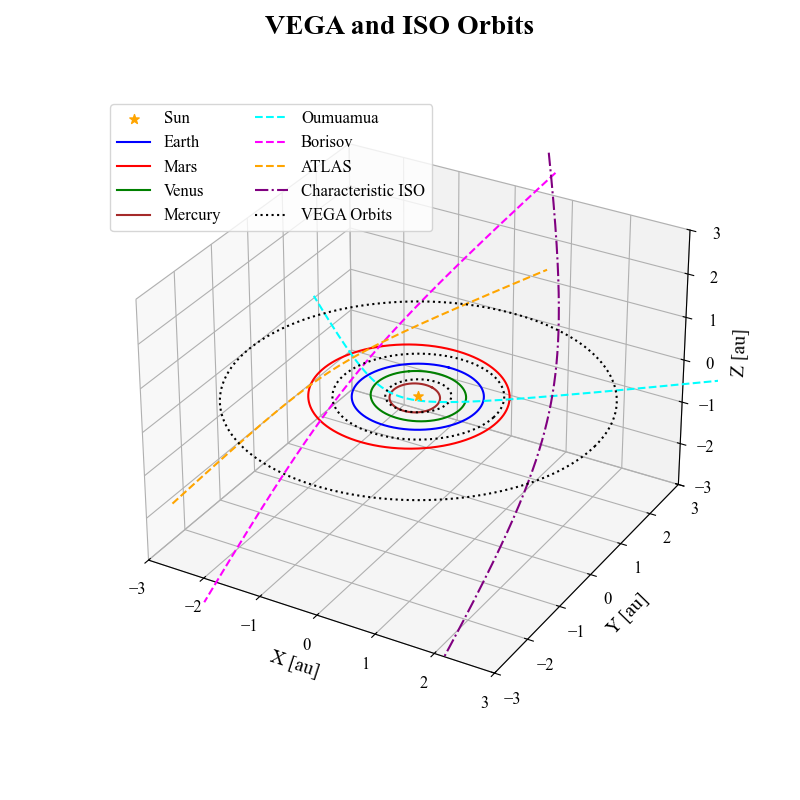

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

fig.suptitle('VEGA and ISO Orbits')
# ax.set_title('VEGA and ISO Orbits')

ax.scatter(0, 0, 0, color='orange', s=50, label='Sun', marker='*')
ax.plot(cropped_rs[0][:, 0], cropped_rs[0][:, 1], cropped_rs[0][:, 2], label='Earth', color='blue')
ax.plot(cropped_rs[1][:, 0], cropped_rs[1][:, 1], cropped_rs[1][:, 2], label='Mars', color='red')
ax.plot(cropped_rs[2][:, 0], cropped_rs[2][:, 1], cropped_rs[2][:, 2], label='Venus', color='green')
ax.plot(cropped_rs[3][:, 0], cropped_rs[3][:, 1], cropped_rs[3][:, 2], label='Mercury', color='brown')

ax.plot(cropped_rs[4][:, 0], cropped_rs[4][:, 1], cropped_rs[4][:, 2], label='Oumuamua', color='cyan', linestyle='--')
ax.plot(cropped_rs[5][:, 0], cropped_rs[5][:, 1], cropped_rs[5][:, 2], label='Borisov', color='magenta', linestyle='--')
ax.plot(cropped_rs[6][:, 0], cropped_rs[6][:, 1], cropped_rs[6][:, 2], label='ATLAS', color='orange', linestyle='--')
ax.plot(cropped_rs[7][:, 0], cropped_rs[7][:, 1], cropped_rs[7][:, 2], label='Characteristic ISO', color='purple', linestyle='-.')

ax.plot(cropped_rs[8][:, 0], cropped_rs[8][:, 1], cropped_rs[8][:, 2], label='VEGA Orbits', color='black', linestyle=':')
ax.plot(cropped_rs[9][:, 0], cropped_rs[9][:, 1], cropped_rs[9][:, 2], color='black', linestyle=':')
ax.plot(cropped_rs[10][:, 0], cropped_rs[10][:, 1], cropped_rs[10][:, 2], color='black', linestyle=':')

# ax.set_aspect('equal')

view = 3
ax.set_xlim([-view, view])
ax.set_ylim([-view, view])
ax.set_zlim([-view, view])

ax.set_xlabel('X [au]')
ax.set_ylabel('Y [au]')
ax.set_zlabel('Z [au]')
ax.legend(loc='upper left', ncol=2)

# fig.savefig('spacecraft_trajectory.png', dpi=300)

plt.show()